# Modeling Correlated Disruption Processes
Prepared by: Nickolas Freeman, PhD

This notebook demonstrates how to incorporate correlated supplier disruptions when limited data is available. In such cases, the fact that limited data is available may lead decision-makers to doubt the correlation estimates suggested by the data. The following code block imports some libraries that we will use.

In [1]:
import pandas as pd
import numpy as np
from ipywidgets import interact
import matplotlib.pyplot as plt
import seaborn as sns
from gurobipy import *

Before looking at the sourcing models, we will consider how data can sometimes not provide a complete picture of the relationships that exist among variables. The following code block reads a files that contains 13 datasets. The first and last five rows are printed.

In [2]:
dozen = pd.read_csv('Dozen.csv')
dataset_names = dozen['dataset'].unique().tolist()
dozen

,dataset,x,y
0,dino,55.384600,97.179500
1,dino,51.538500,96.025600
2,dino,46.153800,94.487200
3,dino,42.820500,91.410300
4,dino,40.769200,88.333300
...,...,...,...
1841,wide_lines,33.674442,26.090490
1842,wide_lines,75.627255,37.128752
1843,wide_lines,40.610125,89.136240
1844,wide_lines,39.114366,96.481751


The following code block prints the mean, meadian, standard deviation, and corrleation for the x and y values associated with the datasets.

In [3]:
dataset_summary = []
for current_dataset_name in dataset_names:
    current_dataset = dozen[dozen['dataset'] == current_dataset_name]
    dataset_summary.append([current_dataset_name,
                            np.round(current_dataset.mean(axis = 0)[0], 2),
                            np.round(current_dataset.mean(axis = 0)[1], 2),
                            np.round(current_dataset.median(axis = 0)[0], 2),
                            np.round(current_dataset.median(axis = 0)[1], 2),
                            np.round(current_dataset.std(axis = 0)[0], 2),
                            np.round(current_dataset.std(axis = 0)[1], 2),
                            np.round(current_dataset.corr().values[0,1], 2)])
    
column_names = ['dataset', 'x_mean', 'y_mean', 'x_median', 'y_median', 'x_std', 'y_std', 'correlation']
pd.DataFrame(dataset_summary,
            columns = column_names)    

,dataset,x_mean,y_mean,x_median,y_median,x_std,y_std,correlation
0,dino,54.26,47.83,53.33,46.03,16.77,26.94,-0.06
1,away,54.27,47.83,53.34,47.54,16.77,26.94,-0.06
2,h_lines,54.26,47.83,53.07,50.47,16.77,26.94,-0.06
3,v_lines,54.27,47.84,50.36,47.11,16.77,26.94,-0.07
4,x_shape,54.26,47.84,47.14,39.88,16.77,26.93,-0.07
5,star,54.27,47.84,56.53,50.11,16.77,26.93,-0.06
6,high_lines,54.27,47.84,54.17,32.50,16.77,26.94,-0.07
7,dots,54.26,47.84,50.98,51.30,16.77,26.93,-0.06
8,circle,54.27,47.84,54.02,51.03,16.76,26.93,-0.07
9,bullseye,54.27,47.83,53.84,47.38,16.77,26.94,-0.07


The following code block generates and interactive visualization that allows us to view the datasets.

In [4]:
dataset_names = dozen['dataset'].unique().tolist()

@interact(current_dataset_name = dataset_names)

def interactive_spend_analysis(current_dataset_name = dataset_names[0]):

    current_dataset = dozen[dozen['dataset'] == current_dataset_name]

    fig, ax = plt.subplots(1, 1, figsize = (8,6))
    sns.scatterplot(x = 'x', y = 'y', data = current_dataset)
    plt.show()

interactive(children=(Dropdown(description='current_dataset_name', options=('dino', 'away', 'h_lines', 'v_line…

We will consider cases where the on-time dlivery rate for suppliers are correlated. The following code block defines an optimization model that maximizes the buyer's expected profit under the assumption that demand is uncertain.

In [5]:
def solve_OTD_model(cost_vector, otd_sample, demand_sample, sales_price):
    
    scenarios = len(demand_sample)
    suppliers = len(cost_vector)

    m = Model(name = 'Sourcing Under All-or-Nothing Disruptions')
    m.setParam('OutputFlag', 0)

    Order = m.addVars(suppliers, vtype = 'C', name="Order")
    Sell = m.addVars(scenarios, vtype = 'C', name = "Sell")
    
    for scenario in range(scenarios):
        total_delivered = LinExpr()
        for supplier in range(suppliers):
            total_delivered.add(Order[supplier]*otd_sample[scenario,supplier])
        m.addConstr(Sell[scenario] <= total_delivered, name = 'Sell <= Delivered')

    for scenario in range(scenarios):
        m.addConstr(Sell[scenario] <= demand_sample[scenario], name = 'Sell <= Demand')

    expected_revenue = LinExpr()
    for scenario in range(scenarios):
        expected_revenue.add(sales_price*Sell[scenario])
    expected_revenue = expected_revenue/scenarios

    expected_cost = LinExpr()
    for scenario in range(scenarios): 
        for supplier in range(suppliers):
            expected_cost.add(cost_vector[supplier]*Order[supplier]\
                              *otd_sample[scenario,supplier])
    expected_cost = expected_cost/scenarios

    objective = expected_revenue - expected_cost
    m.setObjective(objective, GRB.MAXIMIZE) # maximize profit

    m.optimize()
    
    solution_dict = {}
    for supplier in range(suppliers):
        solution_dict[supplier] = Order[supplier].X

    return solution_dict

# Single Group of Correlated Suppliers

Let's first consider the case where the buyer has reason to believe that all of the available suppliers are subject to correlated disruptions. Such a case may arise if all suppliers are located in the same country, all suppliers utilize a common raw material, or all suppliers utilize common shipment modes. The following code block reads in a dataset for such a case and shows how the correlation imputed by the dataset changes as the amount of data available varies.

In [6]:
single_group_sample = pd.read_csv('single_group.csv')
cutoff_list = [10, 15, 20, 25, 50, 100, 250, 500, 1000, 5000, 10000]

@interact(cutoff = cutoff_list)

def interactive_spend_analysis(cutoff = cutoff_list[0]):

    fig, ax = plt.subplots(1, 2, sharey = True, figsize = (16,6))

    sns.heatmap(single_group_sample[:cutoff].corr().values, ax = ax[0], vmin=-1, vmax=1, cmap = 'coolwarm')
    sns.heatmap(single_group_sample.corr().values, ax = ax[1], vmin=-1, vmax=1, cmap = 'coolwarm')
    ax[0].set_title('Imputed Correlation', fontsize = 14)
    ax[1].set_title('True Correlation', fontsize = 14)
    
    plt.show()

interactive(children=(Dropdown(description='cutoff', options=(10, 15, 20, 25, 50, 100, 250, 500, 1000, 5000, 1…

The following code block calculates the on-time delivery rates for each supplier, specifies a unit cost vector for the available suppliers, and creates a list of the supplier names.

In [7]:
marginals = single_group_sample.mean(axis=0).values
cost_vector = np.array([0.74, 0.83, 0.80, 0.87, 0.76])
supplier_names = list(single_group_sample.columns)

The following code block plots the unit cost and on-time delivery rate for each supplier.

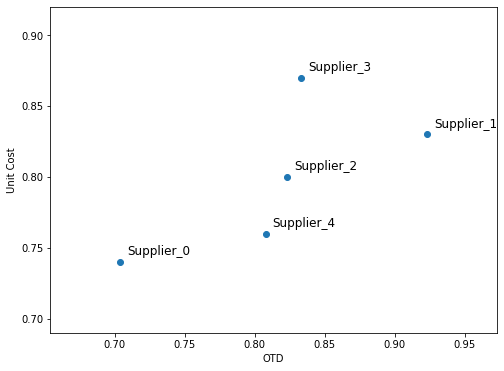

In [8]:
fig, ax = plt.subplots(1, 1, figsize = (8,6))
ax.scatter(x = marginals, y = cost_vector)
ax.set_xlabel('OTD')
ax.set_ylabel('Unit Cost')
ax.set_xlim(min(marginals)-0.05, max(marginals)+0.05)
ax.set_ylim(min(cost_vector)-0.05, max(cost_vector)+0.05)

for (otd_val, cost_val, supplier) in zip(marginals, cost_vector, supplier_names):
    ax.annotate(supplier, (otd_val + 0.005, cost_val + 0.005), fontsize = 12)

plt.show()

The following code block demonstrates how to determine the worst-case supply distribution for each supplier and uses it to solve the stochastic optimization problem. The dropdown box allows users to view how the solution changes as the amount of data used to fit the worst-case distribution varies.

In [9]:
cutoff_list = [5, 10, 15, 20, 25, 50, 100, 1000, 5000, 10000]

@interact(cutoff = cutoff_list)

def interactive_spend_analysis(cutoff = cutoff_list[0]):
    
    np.random.seed(0)
    sample_size = 1000
    demand_sample = np.random.normal(loc = 1000, scale = 100, size = sample_size)

    single_group_data = single_group_sample[:cutoff].copy()
    estimated_marginals = single_group_data.mean(axis=0).values
        
    group_sample = np.random.rand(sample_size)

    otd_sample = np.ones((sample_size, len(estimated_marginals)))

    for column in range(otd_sample.shape[1]):
        otd_sample[:, column] = (group_sample <= estimated_marginals[column]).astype(int)

    solution = solve_OTD_model(cost_vector, otd_sample, demand_sample, 1.0)

    suppliers = list(solution.keys())
    orders = list(solution.values())

    fig, ax = plt.subplots(1, 1, figsize = (8,6))
    ax.scatter(x = marginals, y = cost_vector, s = orders)
    ax.set_xlabel('OTD')
    ax.set_ylabel('Unit Cost')
    ax.set_xlim(min(marginals)-0.05, max(marginals)+0.05)
    ax.set_ylim(min(cost_vector)-0.05, max(cost_vector)+0.05)

    for (otd_val, cost_val, supplier) in zip(marginals, cost_vector, supplier_names):
        ax.annotate(supplier, (otd_val + 0.005, cost_val + 0.005), fontsize = 12)

    plt.show()

interactive(children=(Dropdown(description='cutoff', options=(5, 10, 15, 20, 25, 50, 100, 1000, 5000, 10000), …

# Two Groups of Correlated Suppliers

We will now consider the case where the buying firm believes that the available suppliers can be partitioned into groups, where the suppliers in each group are subject to correlated disruptions. The following code block reads in a dataset for such a case and shows how the correlation imputed by the dataset changes as the amount of data available varies.

In [10]:
two_group_sample = pd.read_csv('Two_Groups.csv')
cutoff_list = [10, 15, 20, 25, 50, 100, 250, 500, 1000, 5000, 10000]

@interact(cutoff = cutoff_list)

def interactive_spend_analysis(cutoff = cutoff_list[0]):

    fig, ax = plt.subplots(1, 2, sharey = True, figsize = (16,6))

    sns.heatmap(two_group_sample[:cutoff].corr().values, ax = ax[0], vmin=-1, vmax=1, cmap = 'coolwarm')
    sns.heatmap(two_group_sample.corr().values, ax = ax[1], vmin=-1, vmax=1, cmap = 'coolwarm')
    ax[0].set_title('Imputed Correlation', fontsize = 14)
    ax[1].set_title('True Correlation', fontsize = 14)

    plt.show()

interactive(children=(Dropdown(description='cutoff', options=(10, 15, 20, 25, 50, 100, 250, 500, 1000, 5000, 1…

The following code block calculates the on-time delivery rates for each supplier, specifies a unit cost vector for the available suppliers, and creates a list of the supplier names.

In [11]:
marginals = two_group_sample.mean(axis=0).values
cost_vector = np.array([0.73, 0.85, 0.77, 0.75, 0.725, 0.71])
supplier_names = list(two_group_sample.columns)

The following code block plots the unit cost and on-time delivery rate for each supplier.

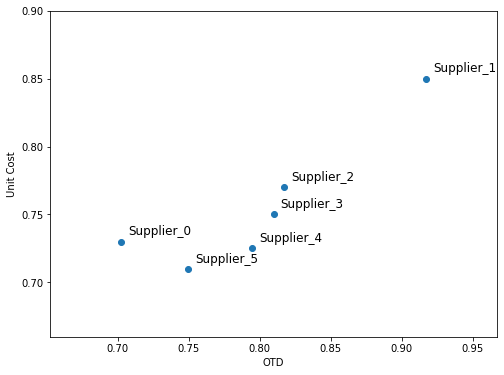

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (8,6))
ax.scatter(x = marginals, y = cost_vector)
ax.set_xlabel('OTD')
ax.set_ylabel('Unit Cost')
ax.set_xlim(min(marginals)-0.05, max(marginals)+0.05)
ax.set_ylim(min(cost_vector)-0.05, max(cost_vector)+0.05)

for (otd_val, cost_val, supplier) in zip(marginals, cost_vector, supplier_names):
    ax.annotate(supplier, (otd_val + 0.005, cost_val + 0.005), fontsize = 12)

plt.show()

The following code block demonstrates how to determine the worst-case supply distribution for the case with supplier groups and uses it to solve the stochastic optimization problem. The dropdown box allows users to view how the solution changes as the amount of data used to fit the worst-case distribution varies.

In [13]:
cutoff_list = [5, 10, 15, 20, 25, 50, 100, 1000, 10000]

@interact(cutoff = cutoff_list)

def interactive_spend_analysis(cutoff = cutoff_list[0]):

    np.random.seed(0)
    sample_size = 1000
    demand_sample = np.random.normal(loc = 1000, scale = 100, size = sample_size)
    
    two_group_data = two_group_sample[:cutoff].copy()
    estimated_marginals = two_group_data.mean(axis=0).values

    np.random.seed(0)
    groups = [0,0,0,1,1,1]
    group_rvs = np.random.rand(sample_size, len(set(groups)))

    correlated_otd_sample = np.ones((sample_size, len(estimated_marginals)))
    
    for column in range(correlated_otd_sample.shape[1]):
        correlated_otd_sample[:,column] = (group_rvs[:,groups[column]] <= estimated_marginals[column]).astype(int)

    solution = solve_OTD_model(cost_vector, correlated_otd_sample, demand_sample, 1.0)

    suppliers = list(solution.keys())
    orders = list(solution.values())

    fig, ax = plt.subplots(1, 1, figsize = (8,6))
    ax.scatter(x = marginals, y = cost_vector, s = orders)
    ax.set_xlabel('OTD')
    ax.set_ylabel('Unit Cost')
    ax.set_xlim(min(marginals)-0.05, max(marginals)+0.05)
    ax.set_ylim(min(cost_vector)-0.05, max(cost_vector)+0.05)

    for (otd_val, cost_val, supplier) in zip(marginals, cost_vector, supplier_names):
        ax.annotate(supplier, (otd_val + 0.005, cost_val + 0.005), fontsize = 12)

    plt.show()

interactive(children=(Dropdown(description='cutoff', options=(5, 10, 15, 20, 25, 50, 100, 1000, 10000), value=…